In [89]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [39]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [90]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


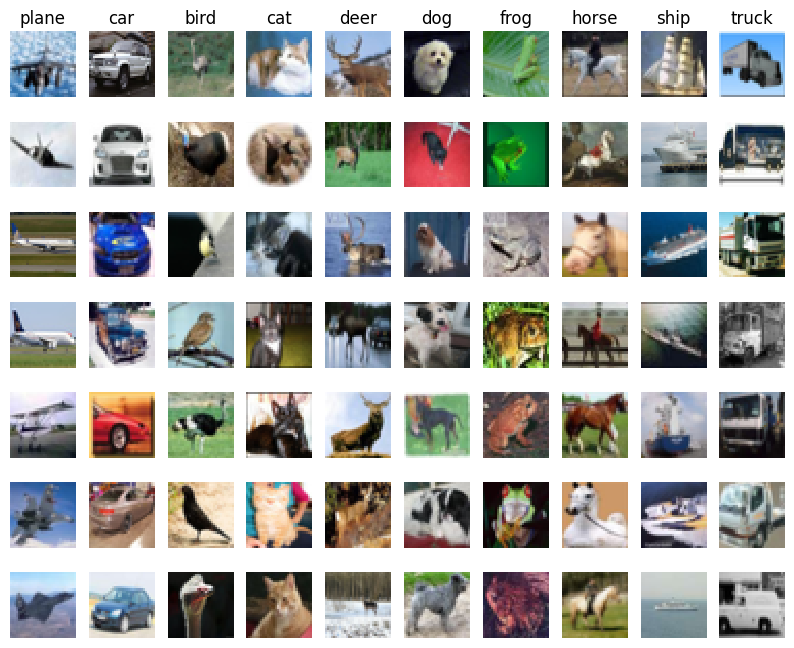

In [91]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [92]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [93]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


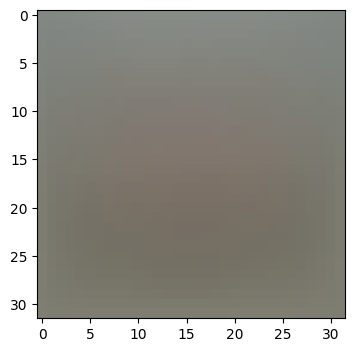

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [94]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [95]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print(f'W Shape: {W.shape}, grad shape: {grad.shape}')
print(f'loss: {loss}, grad: {grad}')

naive:  0 9 2 [-291.22291837 -216.16438776   58.26526531 ...  -82.24236735   12.59614286
   -9.        ]
naive:  1 9 7 [-390.22291837 -279.16438776  -58.73473469 ...  160.75763265  264.59614286
   -9.        ]
naive:  2 8 6 [-218.86481633  -80.14612245   83.79134694 ...  430.89567347  467.19657143
   -8.        ]
naive:  3 9 5 [1148.77708163 1214.83561224 1156.26526531 ... 1105.75763265  921.59614286
   -9.        ]
naive:  4 9 5 [1208.55416327 1088.67122449 1682.53053061 ... 1212.51526531 1087.19228571
  -18.        ]
naive:  5 9 8 [ -381.22291837  -729.16438776 -1048.73473469 ...  -181.24236735
  -347.40385714    -9.        ]
naive:  6 8 0 [589.13518367 383.85387755 859.79134694 ... 342.89567347 779.19657143
  -8.        ]
naive:  7 9 9 [455.77708163 341.83561224 319.26526531 ... -37.24236735 174.59614286
  -9.        ]
naive:  8 9 6 [-609.08773469 -485.3105102  -109.94338776 ...  375.65330612  569.79271429
  -17.        ]
naive:  9 9 8 [ -537.44583673  -990.32877551 -1341.46946939 .

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [96]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print("-------------")

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

Streaming output truncated to the last 5000 lines.
naive:  64 9 2 [1017.906 1317.21  2443.444 ... 1520.472 3091.158  -98.   ]
naive:  65 9 2 [1005.68308163 1497.04561224 2897.70926531 ... 1411.22963265 3166.75414286
 -107.        ]
naive:  66 9 2 [1902.46016327 2306.88122449 3882.97453061 ... 1688.98726531 3467.35028571
 -116.        ]
naive:  67 9 1 [-1997.53357143 -1995.63928571 -2138.41285714 ...  -536.83142857
  -524.015        -35.        ]
naive:  68 9 2 [2115.2372449  2810.71683673 4697.23979592 ... 1705.74489796 3758.94642857
 -125.        ]
naive:  69 9 1 [-1838.7564898  -1770.80367347 -1972.14759184 ... -1006.07379592
  -907.41885714   -44.        ]
naive:  70 9 4 [2506.60161224 2696.21459184 2657.3784898  ... -392.9357551   -85.81842857
  -43.        ]
naive:  71 8 6 [-1305.06714286 -1051.27857143   823.17428571 ...  -603.66285714
  1406.97         -70.        ]
naive:  72 9 3 [-232.78334694 1267.68489796 1303.12212245 ... 3140.06106122 3016.76914286
  -72.        ]
naive:  

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$

The analytic gradient with respect to $W$ for a given $x$ is fixed for that $x$. As a minimal example, for some $W_{ij}$, $i \neq y_j$, and margin > 0, the gradient will be $x_j$. If we change the value of $W_{ij}$ such that margin < 0, the analytic gradient will still be $x_j$, even though it should now be 0. The numeric gradient is aware of this. Decreasing $h$ will decrease the chance of this happening.


In [102]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.686387e+00 computed in 0.049318s
Vectorized loss: 9.686387e+00 computed in 0.030980s
difference: -0.000000


In [117]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
# W_ = np.array([[1, 2, 1],
#                [3, 4, 1],
#                [5, 6, 1],
#                [7, 8, 1]], dtype=np.float32)
# X_dev_ = np.array([[1, 1, 1, 1],
#                    [2, 2, 2, 2]], dtype=np.float32)
# y_dev_ = np.array([2, 1])
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
# _, grad_naive = svm_loss_naive(W_, X_dev_, y_dev_, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
# _, grad_vectorized = svm_loss_vectorized(W_, X_dev_, y_dev_, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print(f'grad_naive {grad_naive}, grad_vectorized {grad_vectorized}' % difference)
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.048687s
Vectorized loss and gradient: computed in 0.020179s
grad_naive [[-2.01654324e+01 -1.96097977e+01 -2.77935004e+00 ...  5.89148792e+00
  -1.46082704e+01 -2.35218782e+01]
 [-2.77720731e+01 -1.74968676e+01  1.14054694e-01 ...  5.03968939e+00
  -2.57757078e+01 -3.33424018e+01]
 [-4.34821043e+01 -1.84613829e+01  1.30143664e+01 ...  5.49384473e+00
  -4.49495827e+01 -4.69595738e+01]
 ...
 [-7.14255216e+00 -1.22694415e+01  6.46418318e+00 ... -9.12857763e+00
   1.60442087e+01 -1.90930369e+01]
 [-2.00784017e+01 -2.15127734e+01  1.59123074e+01 ...  5.78629886e+00
  -3.57239314e+00 -2.01912094e+01]
 [-4.00000067e-03  6.20000018e-02 -2.15999999e-01 ... -2.36000000e-01
   1.59999987e-02 -2.19999981e-02]], grad_vectorized [[-2.01654324e+01 -1.96097977e+01 -2.77935004e+00 ...  5.89148792e+00
  -1.46082704e+01 -2.35218782e+01]
 [-2.77720731e+01 -1.74968676e+01  1.14054694e-01 ...  5.03968939e+00
  -2.57757078e+01 -3.33424018e+01]
 [-4.34821043e+01 -1.846138

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [119]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 778.356247
iteration 100 / 1500: loss 283.586107
iteration 200 / 1500: loss 106.816750
iteration 300 / 1500: loss 41.580602
iteration 400 / 1500: loss 18.971556
iteration 500 / 1500: loss 9.940618
iteration 600 / 1500: loss 6.877148
iteration 700 / 1500: loss 6.042676
iteration 800 / 1500: loss 5.462550
iteration 900 / 1500: loss 5.648004
iteration 1000 / 1500: loss 5.366979
iteration 1100 / 1500: loss 5.645849
iteration 1200 / 1500: loss 5.486506
iteration 1300 / 1500: loss 5.843936
iteration 1400 / 1500: loss 4.879582
That took 18.384028s


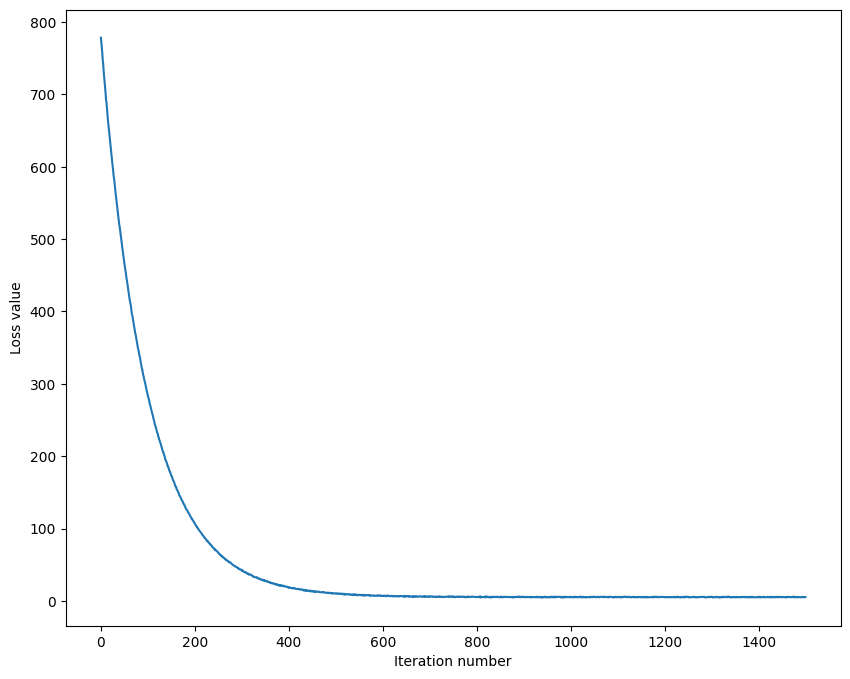

In [120]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [128]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

(3073, 10) (49000, 3073)
training accuracy: 0.370408
(3073, 10) (1000, 3073)
validation accuracy: 0.367000


In [133]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                  num_iters=1500, verbose=True)
        
        y_val_train = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 808.069481
iteration 100 / 1500: loss 294.798152
iteration 200 / 1500: loss 110.974058
iteration 300 / 1500: loss 43.320503
iteration 400 / 1500: loss 19.084709
iteration 500 / 1500: loss 9.968940
iteration 600 / 1500: loss 7.782703
iteration 700 / 1500: loss 6.110977
iteration 800 / 1500: loss 5.200783
iteration 900 / 1500: loss 5.845430
iteration 1000 / 1500: loss 5.323867
iteration 1100 / 1500: loss 5.589562
iteration 1200 / 1500: loss 4.815408
iteration 1300 / 1500: loss 5.078282
iteration 1400 / 1500: loss 4.858092
(3073, 10) (49000, 3073)
(3073, 10) (1000, 3073)
validation accuracy: 0.376000
iteration 0 / 1500: loss 1542.360777
iteration 100 / 1500: loss 208.111353
iteration 200 / 1500: loss 32.457137
iteration 300 / 1500: loss 9.085297
iteration 400 / 1500: loss 6.160760
iteration 500 / 1500: loss 5.467387
iteration 600 / 1500: loss 5.725466
iteration 700 / 1500: loss 5.614597
iteration 800 / 1500: loss 5.604139
iteration 900 / 1500: loss 5.393330
iterat

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in double_scalars
  loss_reg = reg * np.sum(W * W)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in multiply
  loss_reg = reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
(3073, 10) (49000, 3073)
(3073, 10) (1000, 3073)
validation accuracy: 0.055000
iteration 0 / 1500: loss 1540.967277
iteration 100 / 1500: loss 4191633813376022862353173736674006620097951299434208477620663159742886492570721592201241867449793305037475467068139341086720.000000
iteration 200 / 1500: loss 10823845903575198787511266128047541384455120293446108985428903025232566358368803356008032651913555652563768374742170933740780773303424173808134773953194417375159413615977066250058243361517801585236125552093215164181749887499213823519167841566720.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:142: RuntimeWarning: overflow encountered in multiply
  dW = np.transpose(dW_j - dW_y) / n + 2*W*reg
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:106: RuntimeWarning: invalid value encountered in matmul
  Wx_j = np.matmul(WT, XT) # (C, N)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_classifier.py:86: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
(3073, 10) (49000, 3073)
(3073, 10) (1000, 3073)
validation accuracy: 0.087000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370408 val accuracy: 0.376000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.370408 val accuracy: 0.378000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.370408 val accuracy: 0.055000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.370408 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.378000


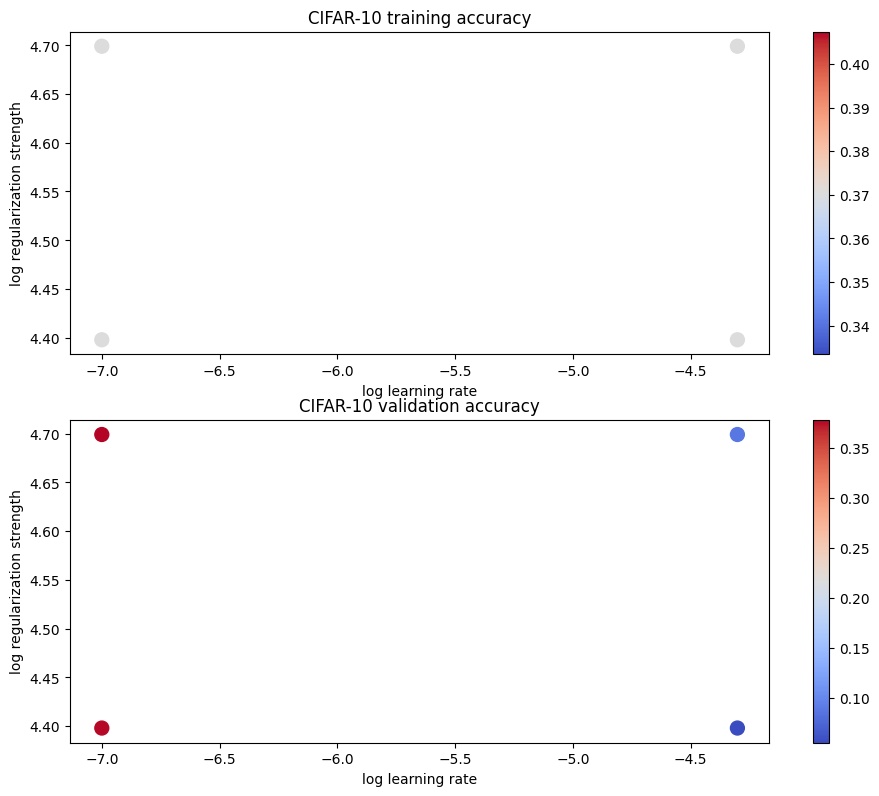

In [134]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [135]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

(3073, 10) (1000, 3073)
linear SVM on raw pixels final test set accuracy: 0.358000


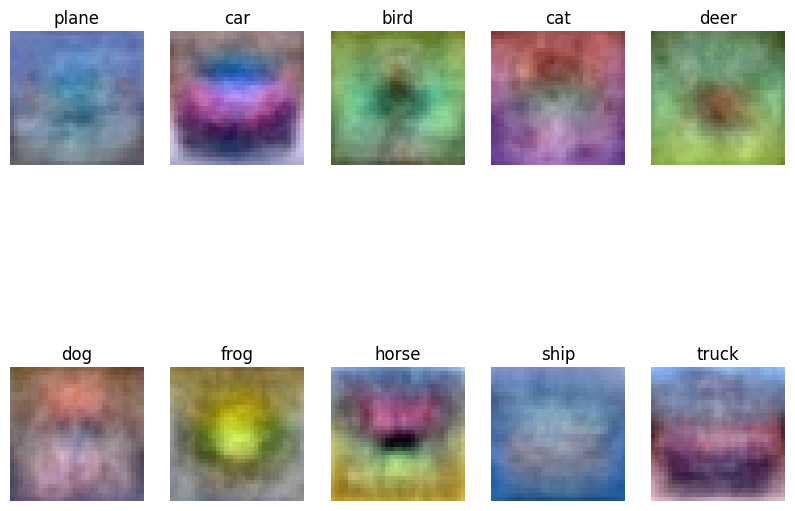

In [136]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$

The weights look grainy and contain vague shapes of the images they are trying to learn. Since SVMs are linear, presumably the learned weights are some kind of linear averaging of all data in a certain class.
